In [2]:
from pathlib import Path
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import shap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans, Birch, OPTICS

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
jfunc_all_data = xr.load_dataset("./data/jfunction_data_med.nc")
X_raw = jfunc_all_data.v.to_numpy()
X_raw_0 = X_raw[0, ~np.any(np.isnan(X_raw[0]), axis=(1,2))]
X_raw_1 = X_raw[1, ~np.any(np.isnan(X_raw[1]), axis=(1,2))]
X_raw_2 = X_raw[2, ~np.any(np.isnan(X_raw[2]), axis=(1,2))]
X = np.concatenate([X_raw_0, X_raw_1, X_raw_2])
X = X.transpose((0,2,1))
y_base = np.concatenate([np.zeros(X_raw_0.shape[0], dtype=int), np.ones(X_raw_1.shape[0], dtype=int), np.full(X_raw_2.shape[0], 2)]).reshape((-1, 1))
oh_enc = OneHotEncoder(sparse_output=False)
y = oh_enc.fit_transform(y_base)
X_train_base, X_test_base, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
abs_max = np.abs(X_train_base - 1).max()
X_train = (X_train_base - 1)/abs_max
X_test = (X_test_base - 1)/abs_max

In [5]:
model = keras.models.load_model("./models/conv12_median.h5")

2025-02-16 16:19:32.259807: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-02-16 16:19:32.259829: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: simul6
2025-02-16 16:19:32.259833: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: simul6
2025-02-16 16:19:32.259956: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2025-02-16 16:19:32.259966: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 525.147.5
2025-02-16 16:19:32.259969: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 525.147.5


In [6]:
class0_idx, *_ = (np.sum(y_train * np.array([1,2,3]), axis=1)-1 == 0).nonzero()
class1_idx, *_ = (np.sum(y_train * np.array([1,2,3]), axis=1)-1 == 1).nonzero()
class2_idx, *_ = (np.sum(y_train * np.array([1,2,3]), axis=1)-1 == 2).nonzero()
np.random.shuffle(class0_idx)
np.random.shuffle(class1_idx)
np.random.shuffle(class2_idx)
sample_amount = 300
sample_idx = np.concatenate([class0_idx[:sample_amount//3], class1_idx[:sample_amount//3], class2_idx[:sample_amount - 2*(sample_amount//3)]])
sample_idx.shape

(300,)

In [7]:
X_train_sample = X_train[sample_idx]
explainer = shap.DeepExplainer(model = model, data = X_train_sample)
shap_values = explainer.shap_values(X_train_sample)
shap_values.shape

/home/simul6/anaconda3/envs/clint_ml/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/home/simul6/anaconda3/envs/clint_ml/lib/python3.11/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


(300, 180, 1, 3)

In [8]:
shap_values.shape

(300, 180, 1, 3)

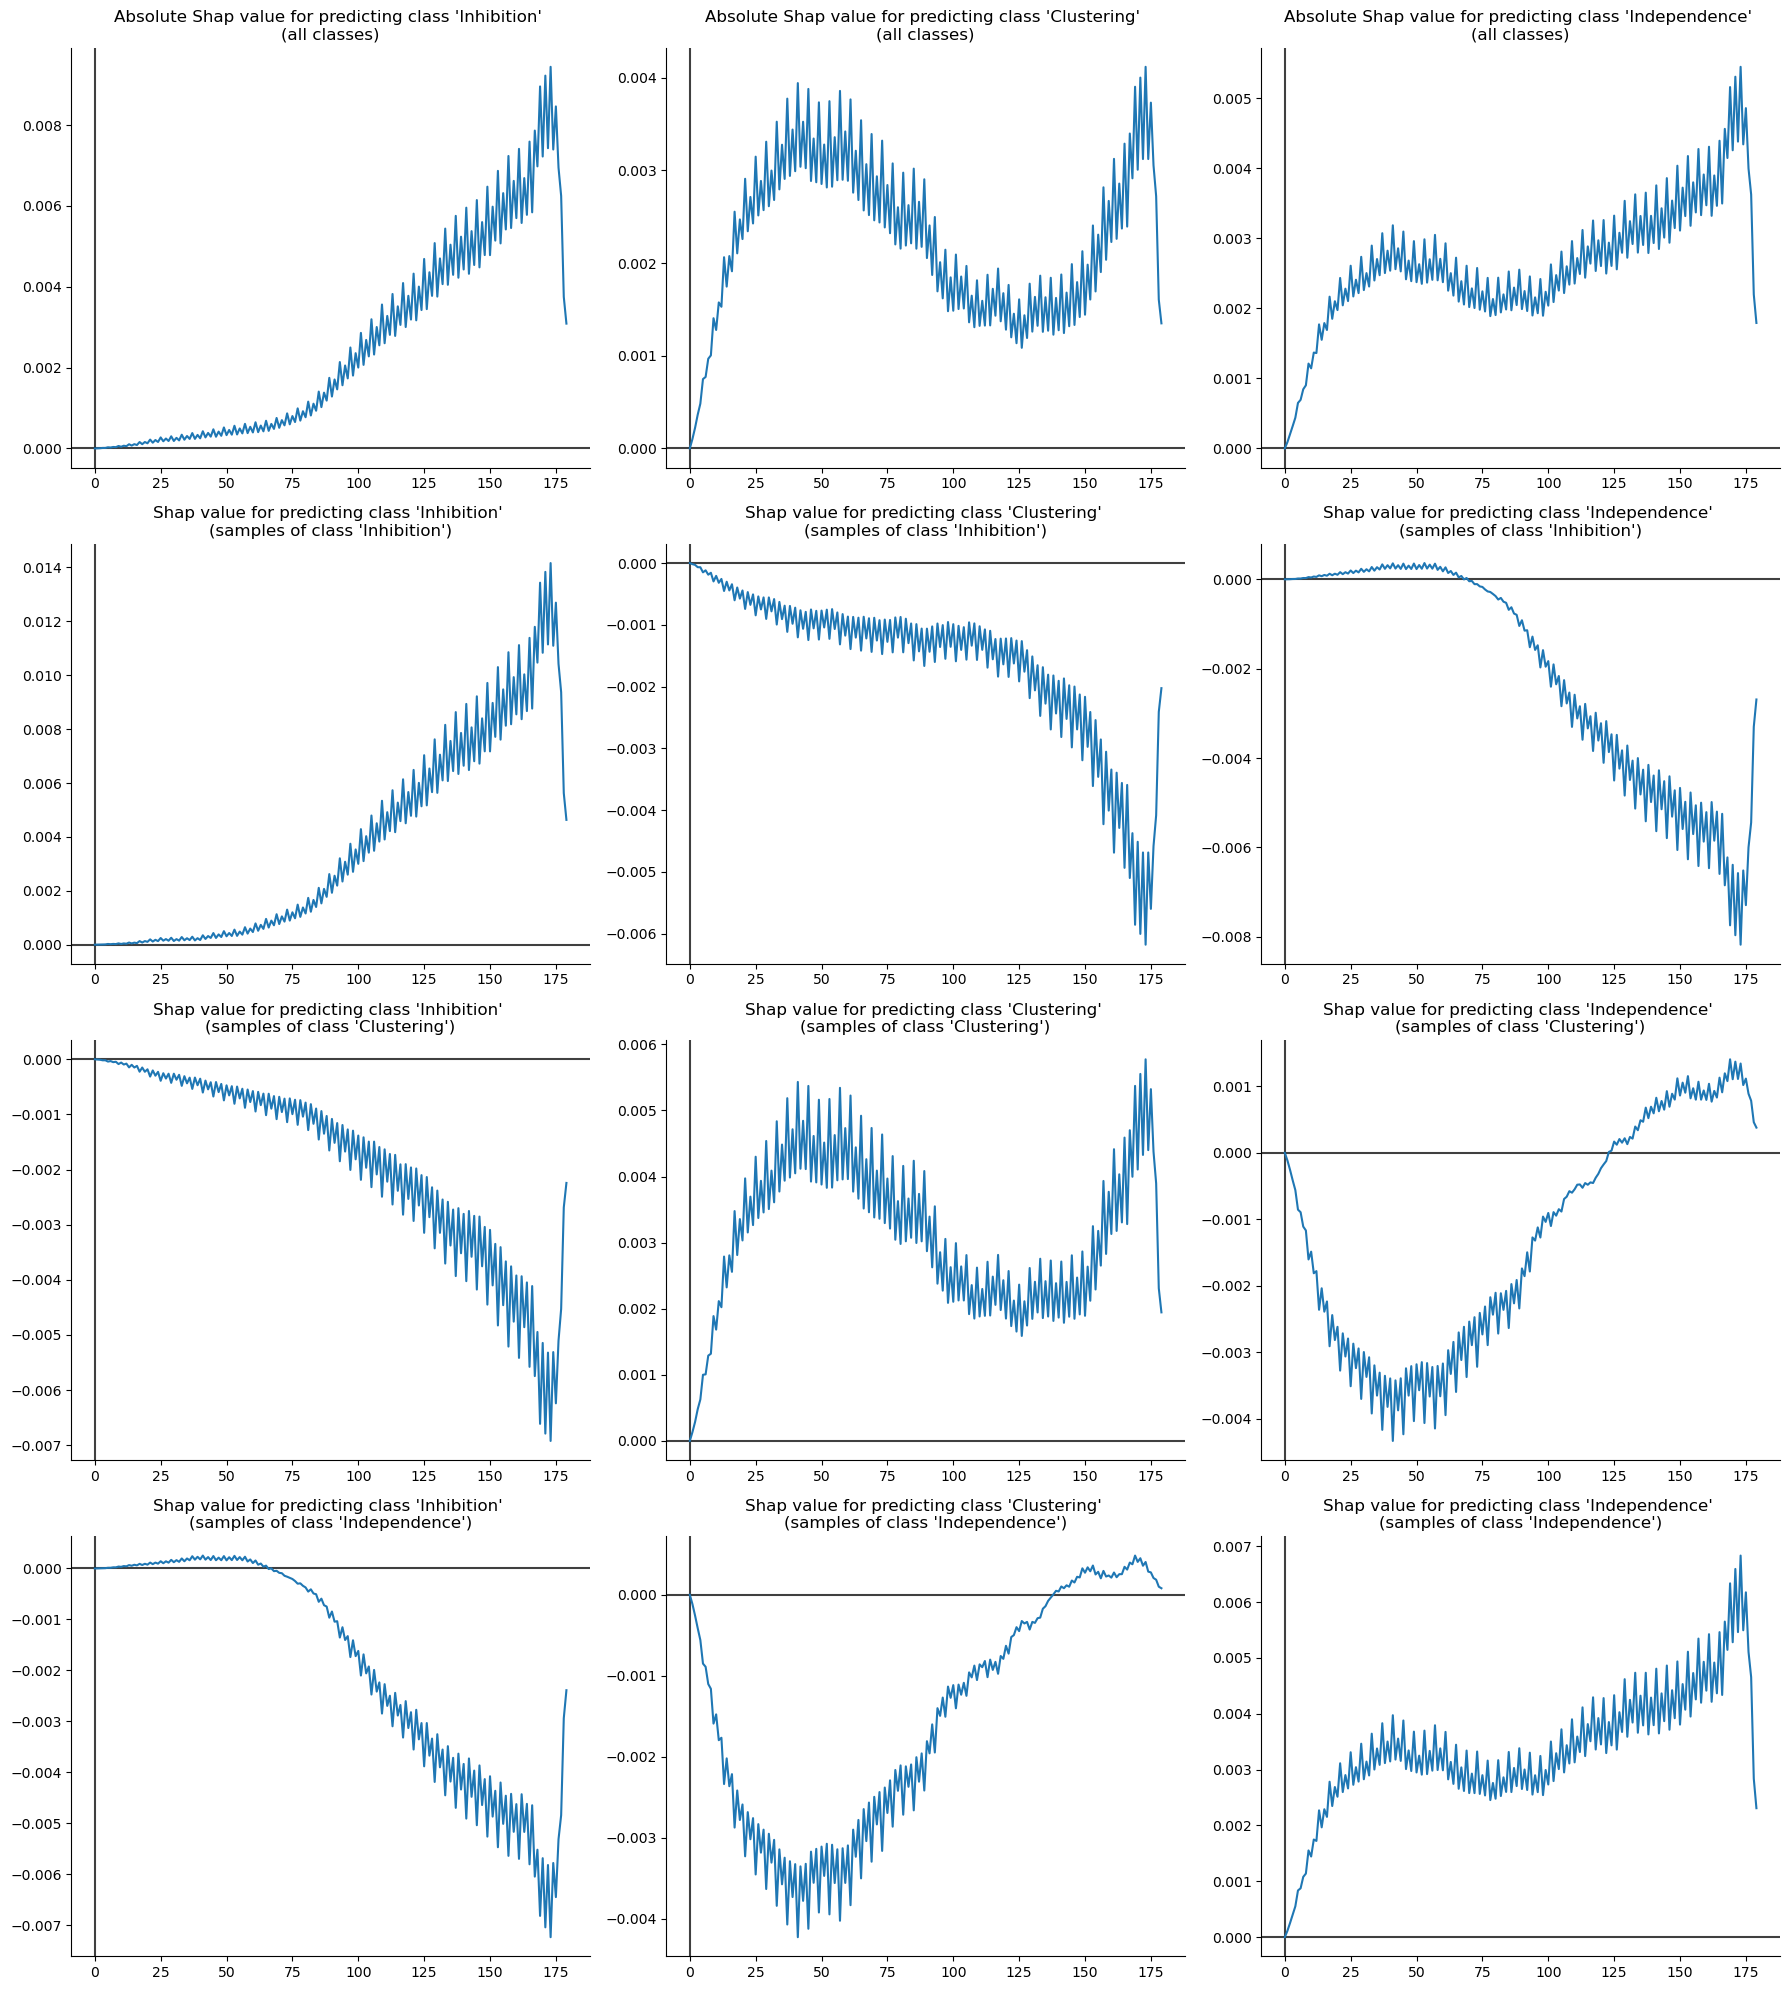

In [9]:
fig, ax = plt.subplots(4, 3, figsize=(18,20))
ax[0,0].plot(np.mean(np.abs(shap_values[:, :, 0, 0]), axis=0))
ax[0,0].set(title="Absolute Shap value for predicting class 'Inhibition' \n(all classes)")
ax[0,1].plot(np.mean(np.abs(shap_values[:, :, 0, 1]), axis=0))
ax[0,1].set(title="Absolute Shap value for predicting class 'Clustering' \n(all classes)")
ax[0,2].plot(np.mean(np.abs(shap_values[:, :, 0, 2]), axis=0))
ax[0,2].set(title="Absolute Shap value for predicting class 'Independence' \n(all classes)")

ax[1,0].plot(np.mean(shap_values[:100, :, 0, 0], axis=0))
ax[1,0].set(title="Shap value for predicting class 'Inhibition' \n(samples of class 'Inhibition')")
ax[1,1].plot(np.mean(shap_values[:100, :, 0, 1], axis=0))
ax[1,1].set(title="Shap value for predicting class 'Clustering' \n(samples of class 'Inhibition')")
ax[1,2].plot(np.mean(shap_values[:100, :, 0, 2], axis=0))
ax[1,2].set(title="Shap value for predicting class 'Independence' \n(samples of class 'Inhibition')")

ax[2,0].plot(np.mean(shap_values[100:200, :, 0, 0], axis=0))
ax[2,0].set(title="Shap value for predicting class 'Inhibition' \n(samples of class 'Clustering')")
ax[2,1].plot(np.mean(shap_values[100:200, :, 0, 1], axis=0))
ax[2,1].set(title="Shap value for predicting class 'Clustering' \n(samples of class 'Clustering')")
ax[2,2].plot(np.mean(shap_values[100:200, :, 0, 2], axis=0))
ax[2,2].set(title="Shap value for predicting class 'Independence' \n(samples of class 'Clustering')")

ax[3,0].plot(np.mean(shap_values[200:, :, 0, 0], axis=0))
ax[3,0].set(title="Shap value for predicting class 'Inhibition' \n(samples of class 'Independence')")
ax[3,1].plot(np.mean(shap_values[200:, :, 0, 1], axis=0))
ax[3,1].set(title="Shap value for predicting class 'Clustering' \n(samples of class 'Independence')")
ax[3,2].plot(np.mean(shap_values[200:, :, 0, 2], axis=0))
ax[3,2].set(title="Shap value for predicting class 'Independence' \n(samples of class 'Independence')")

for i in range(4):
    for j in range(3):
        ax[i,j].axhline(0, color='k', zorder=-100, alpha=0.75)
        ax[i,j].axvline(0, color='k', zorder=-100, alpha=0.75)

sns.despine()
plt.tight_layout()
plt.show()

In [10]:
pred_train = model.predict(X_train)
y_train_disp = oh_enc.inverse_transform(y_train)
pred_train_disp = oh_enc.inverse_transform(pred_train)

pred_test = model.predict(X_test)
y_test_disp = oh_enc.inverse_transform(y_test)
pred_test_disp = oh_enc.inverse_transform(pred_test)

y_train_labels = y_train_disp.flatten()
pred_train_labels = pred_train_disp.flatten()
np.count_nonzero((y_train_labels == 1) & (pred_train_labels == 2)), np.count_nonzero((y_train_labels == 2) & (pred_train_labels == 1))

145/145 [==============================] - 0s 2ms/step


(660, 119)

In [11]:
lg_missed = X_train_base[(y_train_labels == 1) & (pred_train_labels == 2)]
poisson_missed = X_train_base[(y_train_labels == 2) & (pred_train_labels == 1)]

explainer_lg_miss = shap.DeepExplainer(model = model, data = lg_missed)
shap_values_lg_miss = explainer.shap_values(lg_missed)

explainer_poisson_miss = shap.DeepExplainer(model = model, data = poisson_missed)
shap_values_poisson_miss = explainer.shap_values(poisson_missed)

/home/simul6/anaconda3/envs/clint_ml/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


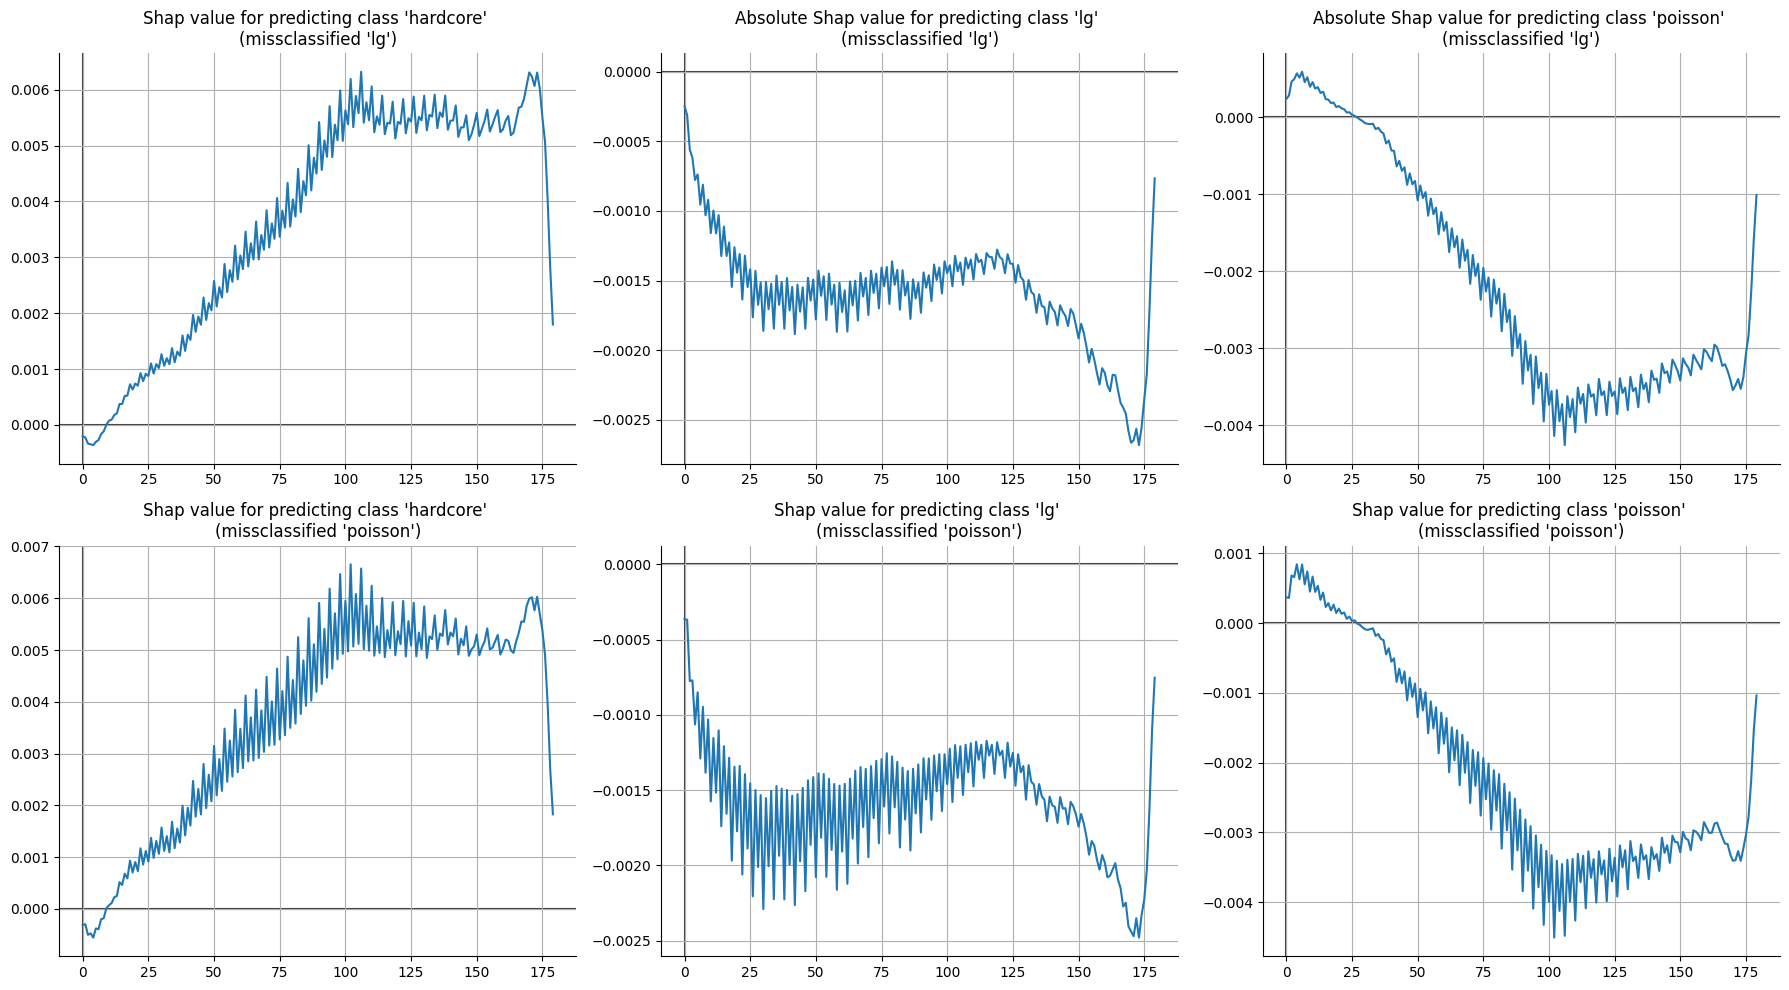

In [20]:
# "Inhibition", "Clustering", "Independence"
fig, ax = plt.subplots(2, 3, figsize=(18,10))
ax[0,0].plot(np.mean(shap_values_lg_miss[:, :, 0, 0], axis=0))
ax[0,0].set(title="Shap value for predicting class 'Inhibition' \n(missclassified 'Clustering')")
ax[0,1].plot(np.mean(shap_values_lg_miss[:, :, 0, 1], axis=0))
ax[0,1].set(title="Absolute Shap value for predicting class 'Clustering' \n(missclassified 'Clustering')")
ax[0,2].plot(np.mean(shap_values_lg_miss[:, :, 0, 2], axis=0))
ax[0,2].set(title="Absolute Shap value for predicting class 'Independence' \n(missclassified 'Clustering')")

ax[1,0].plot(np.mean(shap_values_poisson_miss[:100, :, 0, 0], axis=0))
ax[1,0].set(title="Shap value for predicting class 'Inhibition' \n(missclassified 'Independence')")
ax[1,1].plot(np.mean(shap_values_poisson_miss[:100, :, 0, 1], axis=0))
ax[1,1].set(title="Shap value for predicting class 'Clustering' \n(missclassified 'Independence')")
ax[1,2].plot(np.mean(shap_values_poisson_miss[:100, :, 0, 2], axis=0))
ax[1,2].set(title="Shap value for predicting class 'Independence' \n(missclassified 'Independence')")


for i in range(2):
    for j in range(3):
        ax[i,j].axhline(0, color='k', zorder=-100, alpha=0.75)
        ax[i,j].axvline(0, color='k', zorder=-100, alpha=0.75)
        ax[i,j].grid()

sns.despine()
plt.tight_layout()
plt.show()